# Subgroups

Part of a [Recidivism Case Study](https://allendowney.github.io/RecidivismCaseStudy/)

by [Allen Downey](https://allendowney.com)

[Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)](https://creativecommons.org/licenses/by-nc/4.0/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

The authors of "Machine Bias" published their data and analysis in [this repository](https://github.com/propublica/compas-analysis).

The terms of use for the data [are here](https://www.propublica.org/datastore/terms).  In compliance with those terms, I am not redistributing the data.  The following cell downloads the data file we'll use directly from their repository.

In [2]:
import os

if not os.path.exists('compas-scores-two-years.csv'):
    !wget https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv

The following cell read the data file:

In [3]:
cp = pd.read_csv("compas-scores-two-years.csv")
cp.shape

(7214, 53)

## Code

The functions from the previous notebooks are in a file called `utils.py`; the following cell downloads it if you don't already have it:

In [4]:
import os

if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/RecidivismCaseStudy/master/utils.py

## The reference class problem

In the first notebook we replicated the analysis in the ProPublica article and computed various metrics of accuracy for white and black defendants.  We found that the predictive values (PPV and NPV) were similar for the two groups, but the error rates (FPR and FNR) were substantially different.

In the previous notebook, we ran the same analysis for male and female defendants and found the opposite pattern: the error rates are about the same, but the predictive values are different.

Neither scenario seems completely fair.  Comparing black and white defendants:

* Among non-recidivists, black defendants were more likely to be classified as high risk (false positive).

* Among recidivists, white defendants were more likely to be classified as low risk (false negative).

Comparing male and female defendants:

* Among defendants classified as high risk, female defendants were less likely to recidivate; that is, the test has lower PPV for women.

* Among defendants classified as low risk, male defendants were less likely to "survive"; that is, the test has lower NPV for men.

So it seems like we can't win.  If predictive values are the same for all groups, error rates are not (in general).  And if error rates are the same, predictive values are not.

Nevertheless, the designers of a test like COMPAS can make trade-offs among these kinds of errors.  And that raises two questions I would like to explore:

1. What kind of fairness is COMPAS designed to achieve?  Are they trying to make predictive value the same for all groups?  Or error rates?  Or some compromise?

2. What kind of fairness *should* a test like COMPAS achieve?

To explore the first question, I will compute accuracy metrics for defendants grouped by age, race, and sex, and for the intersections of these groups (explained below).

## Groups

The following function takes a DataFrame containing COMPAS data and a list of variables to group by.  It returns a table with one row for each group and one column for each accuracy metric.

In [5]:
from utils import make_matrix
from utils import compute_metrics

def make_table(cp, group_vars):
    """Make a table of metrics for each subgroup.
    
    cp: DataFrame of COMPAS data
    group_vars: string or list of variable names to group by
    
    returns: DataFrame
    """
    # count the number of defendants in each group
    grouped = cp.groupby(group_vars)
    counts = grouped['id'].count()

    # make the table
    columns = ['FPR', 'FNR', 'PPV', 'NPV', 'Prevalence']
    table = pd.DataFrame(index=counts.index, 
                         columns=columns, 
                         dtype=float)

    # fill in the table
    for name, group in grouped:
        if len(group) < 50:
            continue
        m = make_matrix(group)
        metrics = compute_metrics(m)
        table.loc[name] = metrics['Percent']
    
    table['Count'] = counts
    return table

Here's the table for defendants grouped by race.

In [6]:
table1 = make_table(cp, 'race')
table1

,FPR,FNR,PPV,NPV,Prevalence,Count
race,,,,,,
African-American,44.846797,27.985271,62.971481,65.045992,51.433983,3696
Asian,NaN,NaN,NaN,NaN,NaN,32
Caucasian,23.454301,47.722567,59.133489,71.187500,39.364303,2454
Hispanic,21.481481,55.603448,54.210526,71.140940,36.420722,637
Native American,NaN,NaN,NaN,NaN,NaN,18
Other,14.754098,67.669173,54.430380,69.798658,35.278515,377


Some rows contain `NaN` values because I did not compute metrics for groups with fewer than 50 defendants.

`table1` confirms results from previous analysis and extends them to other groups:

* Predicive values are comparable for all racial groups, although PPV is highest for black defendants and NPV is lowest.

* Error rates are substantially different in different groups.  FPR is highest for black defendants, lower for white and Hispanic defendants, and lowest for defendants in other racial groups.  FNR is highest for Other and lowest for African-American.

The following table shows the breakdown by sex.

In [7]:
table2 = make_table(cp, 'sex')
table2

,FPR,FNR,PPV,NPV,Prevalence,Count
sex,,,,,,
Female,32.107023,39.156627,51.269036,75.746269,35.698925,1395
Male,32.420091,37.086814,63.536317,66.989977,47.310534,5819


Again, these results are consistent with previous analysis.  Comparing male and female defendants, the error rates are comparable, but the predictive values are substantially different.

Next we'll look at the breakdown by age, but first I'll recode the age categories so their ordering in the table is more logical:

In [8]:
cp['age_cat'].value_counts().index

Index(['25 - 45', 'Greater than 45', 'Less than 25'], dtype='object')

In [9]:
d = {'Less than 25':   '1 Younger than 25',
     '25 - 45':        '2 Between 25 - 45', 
     'Greater than 45':'3 Older than 45'}
cp['age_cat_recode'] = cp['age_cat'].replace(d)

Here's the breakdown by age group:

In [10]:
table3 = make_table(cp, 'age_cat_recode')
table3

,FPR,FNR,PPV,NPV,Prevalence,Count
age_cat_recode,,,,,,
1 Younger than 25,54.135338,26.041667,63.963964,57.547170,56.507521,1529
2 Between 25 - 45,33.378378,37.374272,61.486486,67.688787,45.972256,4109
3 Older than 45,16.790353,57.228916,54.060914,75.888325,31.598985,1576


This table shows some patterns we have seen before 

* In groups with high prevalence, FPR is relatively high and FNR relatively low.

* In groups with high prevalence, PPV is relatively hight and NPV relatively low.

But it is still not clear whether COMPAS is trying to achieve constant error rates, constant predictive values, or a compromise between the two.

It is also not clear what we can say about defendants in the intersections of these groups.  What are the metrics for a white male, or an older Hispanic defendant?

I'll compute these intersections in the next section.

## Intersections

In this section I'll compute metrics for defendants grouped by

* Race and sex

* Race and age

* Sex and age

* Race, sex, and age

Then we'll plot the results.

In [11]:
table4 = make_table(cp, ['race', 'sex'])
table4

FPR        FNR        PPV        NPV  \
race             sex                                                  
African-American Female  40.493827  29.959514  51.335312  76.507937   
                 Male    46.115108  27.690447  65.106151  62.054681   
Asian            Female        NaN        NaN        NaN        NaN   
                 Male          NaN        NaN        NaN        NaN   
Caucasian        Female  30.163043  43.216080  50.446429  74.927114   
                 Male    21.250000  48.891786  62.222222  70.167064   
Hispanic         Female  10.000000  72.727273  56.250000  72.413793   
                 Male    23.880597  52.763819  54.022989  70.833333   
Native American  Female        NaN        NaN        NaN        NaN   
                 Male          NaN        NaN        NaN        NaN   
Other            Female  11.538462  66.666667  45.454545  82.142857   
                 Male    15.625000  67.796610  55.882353  66.942149   

                         Prevalence  Count  
race             sex                        
African-American Female   37.883436    652  
                 Male     54.336399   3044  
Asian            Female         NaN      2  
                 Male           NaN     30  
Caucasian        Female   35.097002    567  
                 Male     40.646529   1887  
Hispanic         Female   32.038835    103  
                 Male     37.265918    534  
Native American  Female         NaN      4  
                 Male           NaN     14  
Other            Female   22.388060     67  
                 Male     38.064516    310

In [12]:
table5 = make_table(cp, ['race', 'age_cat_recode'])
table5

FPR        FNR        PPV  \
race             age_cat_recode                                       
African-American 1 Younger than 25  59.888579  23.172906  66.718266   
                 2 Between 25 - 45  44.095941  27.657658  62.685402   
                 3 Older than 45    31.818182  41.304348  54.655870   
Asian            1 Younger than 25        NaN        NaN        NaN   
                 2 Between 25 - 45        NaN        NaN        NaN   
                 3 Older than 45          NaN        NaN        NaN   
Caucasian        1 Younger than 25  48.743719  26.701571  59.071730   
                 2 Between 25 - 45  26.809651  46.996466  60.000000   
                 3 Older than 45     9.576427  68.899522  55.555556   
Hispanic         1 Younger than 25  47.540984  36.363636  59.154930   
                 2 Between 25 - 45  18.534483  59.259259  56.122449   
                 3 Older than 45    13.392857  80.645161  28.571429   
Native American  1 Younger than 25        NaN        NaN        NaN   
                 2 Between 25 - 45        NaN        NaN        NaN   
                 3 Older than 45          NaN        NaN        NaN   
Other            1 Younger than 25  45.238095  47.500000  52.500000   
                 2 Between 25 - 45  10.791367  73.239437  55.882353   
                 3 Older than 45     3.174603  86.363636  60.000000   

                                          NPV  Prevalence  Count  
race             age_cat_recode                                   
African-American 1 Younger than 25  52.554745   60.978261    920  
                 2 Between 25 - 45  66.374589   50.592525   2194  
                 3 Older than 45    71.641791   39.518900    582  
Asian            1 Younger than 25        NaN         NaN      7  
                 2 Between 25 - 45        NaN         NaN     14  
                 3 Older than 45          NaN         NaN     11  
Caucasian        1 Younger than 25  66.666667   48.974359    390  
                 2 Between 25 - 45  67.241379   43.140244   1312  
                 3 Older than 45    77.322835   27.792553    752  
Hispanic         1 Younger than 25  57.142857   51.968504    127  
                 2 Between 25 - 45  70.260223   36.784741    367  
                 3 Older than 45    79.508197   21.678322    143  
Native American  1 Younger than 25        NaN         NaN      3  
                 2 Between 25 - 45        NaN         NaN     12  
                 3 Older than 45          NaN         NaN      3  
Other            1 Younger than 25  54.761905   48.780488     82  
                 2 Between 25 - 45  70.454545   33.809524    210  
                 3 Older than 45    76.250000   25.882353     85

In [13]:
table6 = make_table(cp, ['sex', 'age_cat'])
table6

FPR        FNR        PPV        NPV  \
sex    age_cat                                                       
Female 25 - 45          29.411765  40.764331  56.193353  73.109244   
       Greater than 45  15.283843  66.197183  40.677966  80.497925   
       Less than 25     61.714286  17.699115  46.268657  77.011494   
Male   25 - 45          34.510712  36.698413  62.586315  66.179052   
       Greater than 45  17.196702  55.737705  56.417910  74.707758   
       Less than 25     51.428571  27.296937  68.421053  53.724605   

                        Prevalence  Count  
sex    age_cat                             
Female 25 - 45           38.909542    807  
       Greater than 45   23.666667    300  
       Less than 25      39.236111    288  
Male   25 - 45           47.698365   3302  
       Greater than 45   33.463950   1276  
       Less than 25      60.515713   1241

In [14]:
table7 = make_table(cp, ['race', 'sex', 'age_cat_recode'])
table7

FPR        FNR        PPV  \
race             sex    age_cat_recode                                       
African-American Female 1 Younger than 25  63.440860  19.736842  50.833333   
                        2 Between 25 - 45  36.475410  34.437086  52.659574   
                        3 Older than 45    23.529412  35.000000  44.827586   
                 Male   1 Younger than 25  58.646617  23.711340  70.342205   
                        2 Between 25 - 45  46.309524  26.590198  64.409881   
                        3 Older than 45    33.802817  41.904762  55.963303   
Asian            Female 2 Between 25 - 45        NaN        NaN        NaN   
                        3 Older than 45          NaN        NaN        NaN   
                 Male   1 Younger than 25        NaN        NaN        NaN   
                        2 Between 25 - 45        NaN        NaN        NaN   
                        3 Older than 45          NaN        NaN        NaN   
Caucasian        Female 1 Younger than 25  70.000000   3.703704  38.235294   
                        2 Between 25 - 45  29.213483  41.221374  59.689922   
                        3 Older than 45    13.076923  75.609756  37.037037   
                 Male   1 Younger than 25  39.568345  30.487805  67.455621   
                        2 Between 25 - 45  26.056338  48.735632  60.107817   
                        3 Older than 45     8.474576  67.261905  61.111111   
Hispanic         Female 1 Younger than 25        NaN        NaN        NaN   
                        2 Between 25 - 45   7.142857  80.952381  57.142857   
                        3 Older than 45          NaN        NaN        NaN   
                 Male   1 Younger than 25  52.941176  37.288136  57.812500   
                        2 Between 25 - 45  21.052632  55.263158  56.043956   
                        3 Older than 45    13.829787  76.923077  31.578947   
Native American  Female 2 Between 25 - 45        NaN        NaN        NaN   
                        3 Older than 45          NaN        NaN        NaN   
                 Male   1 Younger than 25        NaN        NaN        NaN   
                        2 Between 25 - 45        NaN        NaN        NaN   
                        3 Older than 45          NaN        NaN        NaN   
Other            Female 1 Younger than 25        NaN        NaN        NaN   
                        2 Between 25 - 45        NaN        NaN        NaN   
                        3 Older than 45          NaN        NaN        NaN   
                 Male   1 Younger than 25  46.666667  45.945946  58.823529   
                        2 Between 25 - 45  12.612613  75.806452  51.724138   
                        3 Older than 45     3.921569  84.210526  60.000000   

                                                 NPV  Prevalence  Count  
race             sex    age_cat_recode                                   
African-American Female 1 Younger than 25  69.387755   44.970414    169  
                        2 Between 25 - 45  74.879227   38.227848    395  
                        3 Older than 45    88.135593   22.727273     88  
                 Male   1 Younger than 25  48.888889   64.580559    751  
                        2 Between 25 - 45  63.881020   53.307393   1799  
                        3 Older than 45    68.115942   42.510121    494  
Asian            Female 2 Between 25 - 45        NaN         NaN      1  
                        3 Older than 45          NaN         NaN      1  
                 Male   1 Younger than 25        NaN         NaN      7  
                        2 Between 25 - 45        NaN         NaN     13  
                        3 Older than 45          NaN         NaN     10  
Caucasian        Female 1 Younger than 25  94.736842   31.034483     87  
                        2 Between 25 - 45  70.000000   42.394822    309  
                        3 Older than 45    78.472222   23.976608    171  
                 Male   1 Younger than 25  62.686567   5

These tables show how much these metrics vary between groups:

* 

In [15]:
tables = [table1, table2, table3, table4, table5, table6, table7]

all_groups = pd.concat(tables)

In [16]:
def min_max_metric(all_groups, metric):
    """
    """
    idx = all_groups[metric].idxmax()
    print(idx, all_groups[metric][idx])
    
    idx = all_groups[metric].idxmin()
    print(idx, all_groups[metric][idx])

Here are the groups with maximumn and minimum FPR:

In [17]:
min_max_metric(all_groups, 'FPR')

('Caucasian', 'Female', '1 Younger than 25') 70.0
('Other', '3 Older than 45') 3.1746031746031744


And here are the results for the other metrics:

In [18]:
min_max_metric(all_groups, 'FNR')

('Other', '3 Older than 45') 86.36363636363636
('Caucasian', 'Female', '1 Younger than 25') 3.7037037037037033


In [19]:
min_max_metric(all_groups, 'PPV')

('African-American', 'Male', '1 Younger than 25') 70.34220532319392
('Hispanic', '3 Older than 45') 28.57142857142857


In [20]:
min_max_metric(all_groups, 'NPV')

('Caucasian', 'Female', '1 Younger than 25') 94.73684210526315
('Other', 'Male', '1 Younger than 25') 48.484848484848484


In [21]:
min_max_metric(all_groups, 'Prevalence')

('African-American', 'Male', '1 Younger than 25') 64.58055925432757
('Hispanic', 'Male', '3 Older than 45') 21.666666666666668


Looking at these results, I have a few thoughts:

1. The differences between groups are big.  FNR, which ranges from about 4% to 86%, is particularly striking.

2. For some metrics the most extreme groups are relatively small groups, so that might not be meaningful.  Statistically it is easier for a small group to deviate from the overall averages.

3. It is not clear from these results how much of the variation between groups is due to differences in prevalance.  I'll explore this relationship in the next section.




## Reverse engineering



In [22]:
from utils import predictive_value
from utils import error_rates

matrix_all = make_matrix(cp)
ppv, npv = predictive_value(matrix_all)
fpr, fnr = error_rates(matrix_all)



In [23]:
from utils import constant_error_rates

prevalences = np.linspace(20, 65, 11)

pred_pv = pd.DataFrame(columns=['ppv', 'npv'])

for prev in prevalences:
    m = constant_error_rates(fpr, fnr, prev)
    pred_pv.loc[prev] = predictive_value(m)

pred_pv

,ppv,npv
20.0,32.603329,87.856159
24.5,38.571828,84.787671
29.0,44.145209,81.577315
33.5,49.361450,78.215019
38.0,54.253815,74.689735
42.5,58.851558,70.989317
47.0,63.180516,67.100383
51.5,67.263589,63.008148
56.0,71.121148,58.696245
60.5,74.771374,54.146498


In [24]:
from utils import constant_predictive_value

prevalences = np.linspace(35, 55, 11)

pred_er = pd.DataFrame(columns=['FPR', 'FNR'])

for prev in prevalences:
    m = constant_predictive_value(ppv, npv, prev)
    pred_er.loc[prev] = error_rates(m)
    
pred_er

,FPR,FNR
35.0,7.488034,77.925569
37.0,11.795671,68.118564
39.0,16.385776,59.317406
41.0,21.287075,51.374897
43.0,26.532324,44.171227
45.0,32.159046,37.607882
47.0,38.210427,31.603121
49.0,44.736425,26.088543
51.0,51.795158,21.006482
53.0,59.454634,16.307973


In [25]:
from utils import plot_cpv_model

In [26]:
from utils import plot_cer_model

Those are all the possible subgroups for these three variables.

Now we can see what the results look like.

The following function plots one data point per subgroup showing the given metric versus prevalence.

Groups with a small number of people are shown with lighter colors.


In [27]:
def plot_table_var(table, var, color):
    """Plot one data point per row.
    
    table: DataFrame
    var: which metric to plot
    color: string
    """
    plt.plot(table['Prevalence'], table[var],
                 'o', color=color, alpha=0.6)

Here's what the results look like for FPR.

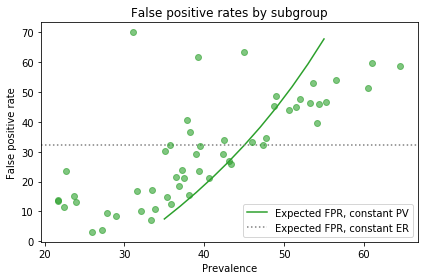

In [28]:
from utils import decorate

pred_er['FPR'].plot(label='Expected FPR, constant PV', color='C2')
plt.axhline(fpr, linestyle='dotted', color='gray',
            label='Expected FPR, constant ER')

for table in tables:
    plot_table_var(table, 'FPR', 'C2')
    
decorate(xlabel='Prevalence',
         ylabel='False positive rate',
         title='False positive rates by subgroup')
plt.legend();

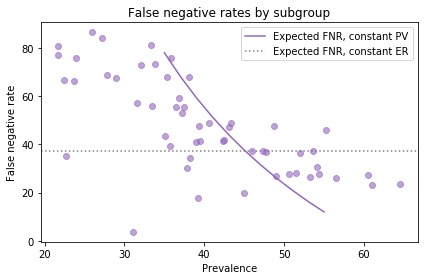

In [29]:
pred_er['FNR'].plot(label='Expected FNR, constant PV', color='C4')
plt.axhline(fnr, linestyle='dotted', color='gray',
            label='Expected FNR, constant ER')

for table in tables:
    plot_table_var(table, 'FNR', 'C4')
    
decorate(xlabel='Prevalence',
         ylabel='False negative rate',
         title='False negative rates by subgroup')
plt.legend();

In general, groups with higher prevalence have higher false positive rates, but the effect is less extreme than what we would expect from the CPV model.

Here are the results for positive predictive value.

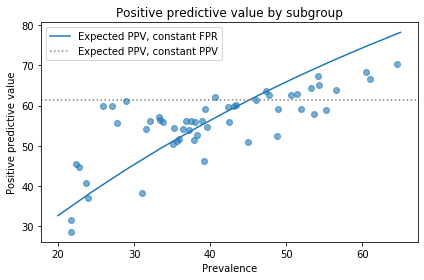

In [30]:
pred_pv['ppv'].plot(label='Expected PPV, constant FPR', color='C0')
plt.axhline(ppv, linestyle='dotted', color='gray',
            label='Expected PPV, constant PPV')

for table in tables:
    plot_table_var(table, 'PPV', 'C0')
    
decorate(xlabel='Prevalence',
         ylabel='Positive predictive value',
         title='Positive predictive value by subgroup')

plt.legend();

Groups with higher prevalence have higher PPV, but the effect is less extreme than we would expect from the CPV model.

Here are the results for false negative rate.

Groups with higher prevalence have lower FNR, but the effect is less extreme than we would expect from the CPV model.

Here are the results for negative predictive value.

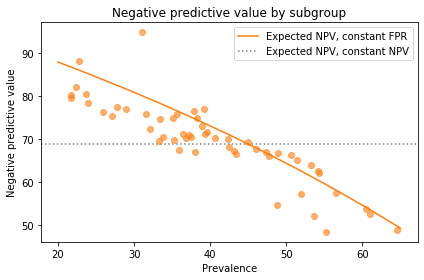

In [31]:
pred_pv['npv'].plot(label='Expected NPV, constant FPR', color='C1')
plt.axhline(npv, linestyle='dotted', color='gray',
            label='Expected NPV, constant NPV')

for table in tables:
    plot_table_var(table, 'NPV', 'C1')
    
decorate(xlabel='Prevalence',
         ylabel='Negative predictive value',
         title='Negative predictive value by subgroup')

plt.legend();

Groups with higher prevalence have lower NPV.  In this case, the effect is almost exactly what we would expect from the CPV model.